# Cognitive and Neural Dynamics Lab Tutorials
## Filters

##### Torben Noto 2015

#### Filters are complicated
but they are incredibly useful. Having a detailed understanding of filtering methods is necessary for correctly performing electrophysiological analyses.

In this notebook, I'm going to provide a broad but shallow overview of how filters basically work. There are many resources available for understanding filtering. This is just an introduction.

In [1]:
#setting settings and loading modules
from __future__ import division

%config InlineBackend.figure_format = 'retina'
%pylab inline

import time
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal
from ipywidgets import interactive, IntSlider, FloatSlider, fixed
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


So what *is* a filter and why do we use them?

Filters are rad because they can isolate certain frequency bands in any oscillating signal.
Here's an example:

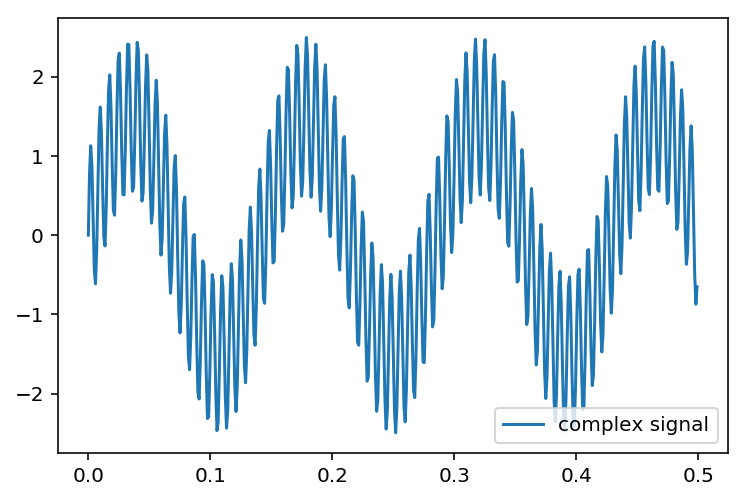

In [2]:
f = 1024 #sampling frequency
dur = 10 #10 seconds of signal
freq = 7 #7 Hz signal
freq2 = 130 #130 Hz signal
t = arange(0, dur, 1/f) #times for d
sig1 = sin(2 * pi * freq * t) #10 Hz wavelength
sig1 = 1.5*sig1; #increase the power of signal 1
sig2 = sin(2 *pi * freq2 * t) #130 Hz wavelength
complex_signal = sig1+sig2;
plt.plot(t[0:512],complex_signal[0:512], label = 'complex signal') #plot 0.5 seconds of data
legend()

This signal is composed of two sin waves oscillating at different frequencies, a high-amplitude, slow frequency wave and a low-amplitude, high frequency wave. We can use a **filter** to get just one component of this complex wave and ignore everything else.
Like this:|

In [3]:
#Ignore the details of these functions for now
def butter_bandpass(lowcut, highcut, fs, order=4):
    #lowcut is the lower bound of the frequency that we want to isolate
    #hicut is the upper bound of the frequency that we want to isolate
    #fs is the sampling rate of our data
    nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = sp.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.signal.filtfilt(b, a, mydata)
    return y

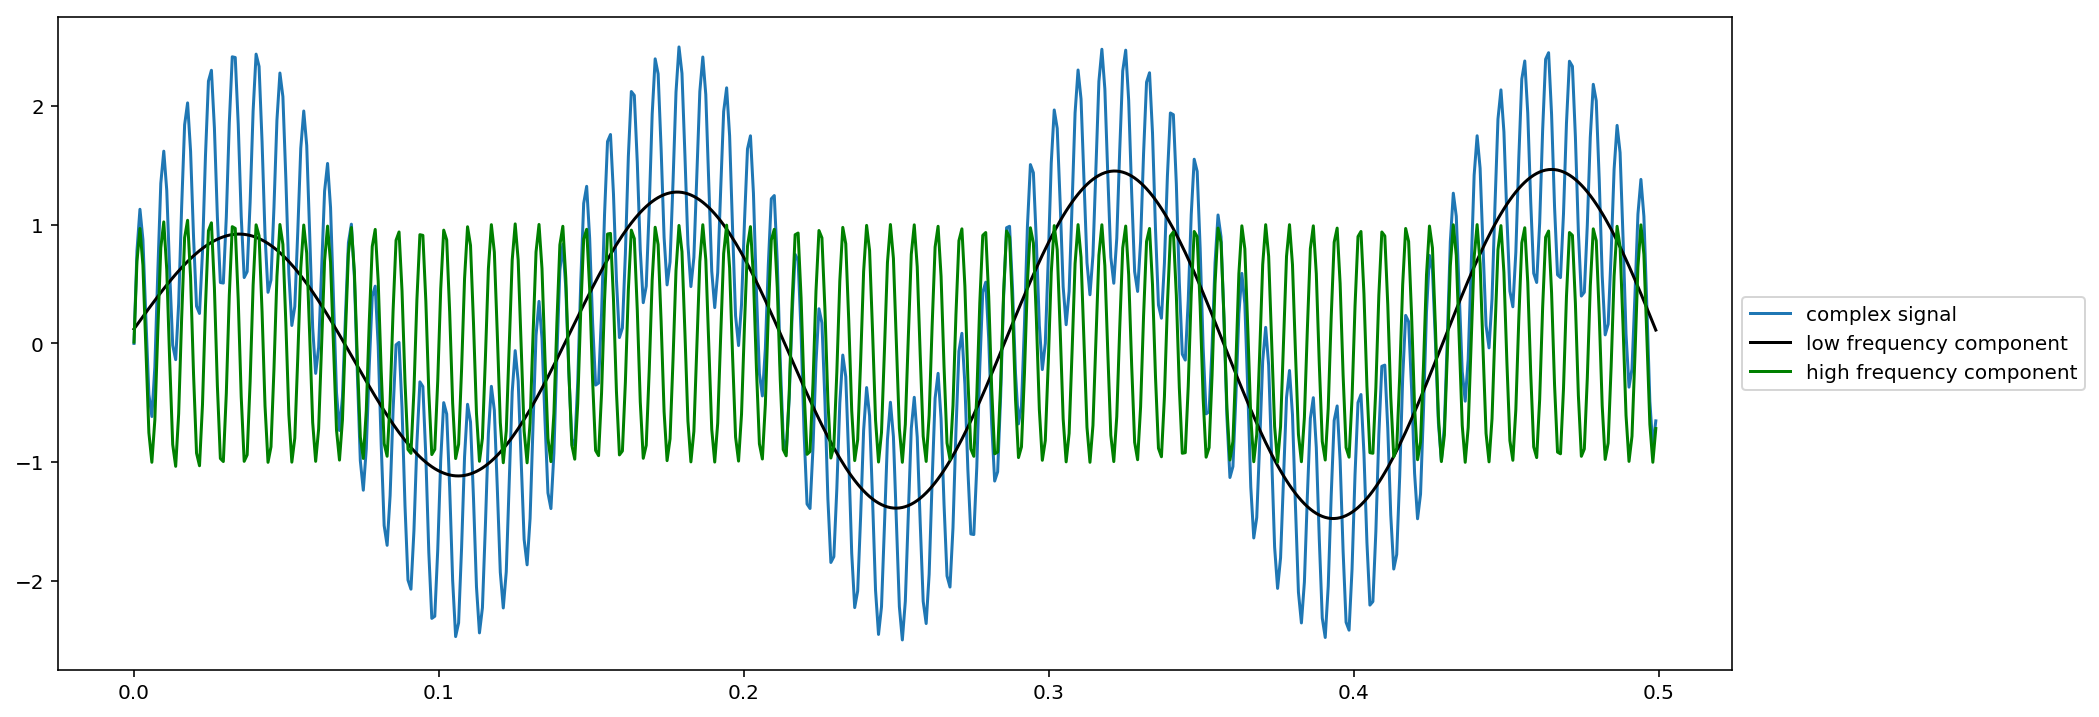

In [4]:
#Using filters to isolate high and low frequencies
low_filtered_dat = butter_bandpass_filter(complex_signal,6,8,1024);
hi_filtered_dat = butter_bandpass_filter(complex_signal,120,140,1024);

figure(figsize = (15,6));
plt.plot(t[0:512],complex_signal[0:512], label = 'complex signal') #plot 0.5 seconds of data
plt.plot(t[0:512],low_filtered_dat[0:512], color = 'k', label = 'low frequency component') #plot 0.5 seconds of low frequency signal
plt.plot(t[0:512],hi_filtered_dat[0:512], color = 'g', label = 'high frequency component') #plot 0.5 seconds of high frequency signal
legend(loc='center left', bbox_to_anchor=(1, 0.5))

In the plot above, I used a filter called the Butterworth filter to seperate out the two freqencies present in a complex signal. This could be useful if, for example, that high frequency wave is noise and we're only interested in the lower frequency one.  
There are many types of filters and none of them are perfect. Each filter has advantages and disadvantages and the details of these are important but I won't cover them here.

A Butterworth filter takes in 3 parameters:
- The sampling rate of the data
- A lower bound on the frequency band you want to keep
- An upper bound on the frequency band you want to keep
- An order of the filter. This determines how *sharply* the filter cuts off bounding frequencies.

If you run this notebook locally, you can use the output of the next cell to play with a filter on some ECoG data to see what kinds of features of the signal that you can pick out in different frequency bands.

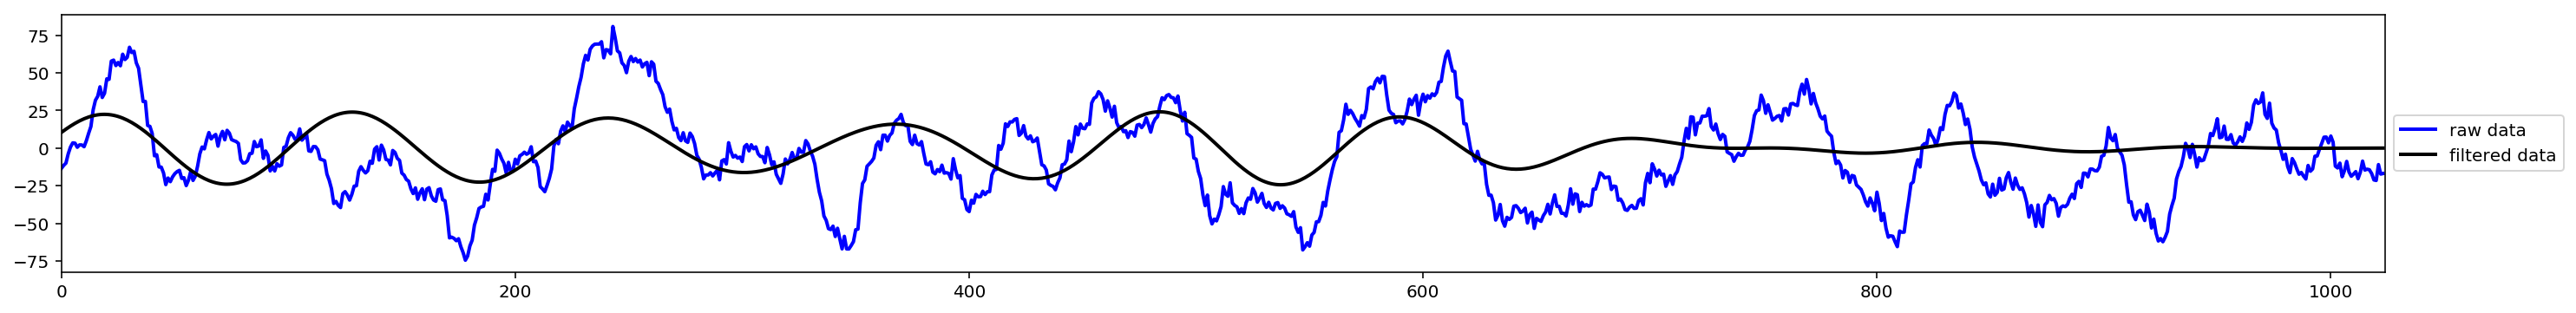

In [5]:
filename = 'emodat.mat'
filename = os.path.join('./', filename)
data = sp.io.loadmat(filename)
srate = data['srate'];
data = data['data']; # time series
data = data[0, :];
dat = data[0:1024];
def filter_dat(lo_cut,hi_cut,order):    

    filtdat = butter_bandpass_filter(dat,lo_cut,hi_cut,srate,order);
    fig = plt.figure(figsize=(24,6))
    ax1 = fig.add_subplot(2, 1, 1)
    plt.plot(dat,lw=2,color='blue',label = 'raw data')
    plt.plot(filtdat,lw=2,color='black',label='filtered data')
    plt.xlim(0, 1024)
    legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    return

a_slider = IntSlider(min=2, max=80, step=1, value=8)
b_slider = FloatSlider(min=2, max=150, step=1, value=12)
c_slider = FloatSlider(min=1, max=8, step=1, value=4)

w=interactive(filter_dat,lo_cut=a_slider,hi_cut=b_slider,order=c_slider)

display(w)

So far, I've been trying to provide you with an intuition for what a filter can do.

Now we're going to look at how a simple filter works, mathematically:



The simplest filter is a convolution filter. In this kind of filter, we slide a shape (often called a kernal) along the data. As it passes along the data, each point on the kernal multiplies a point on the data. In the next cell we'll see what happens if we slide a gaussian distribution (a pretty common filter) along a delta function (zeros with one 1) and some real ECoG data.

Text(0.5,1,'Filtering a Delta Function')

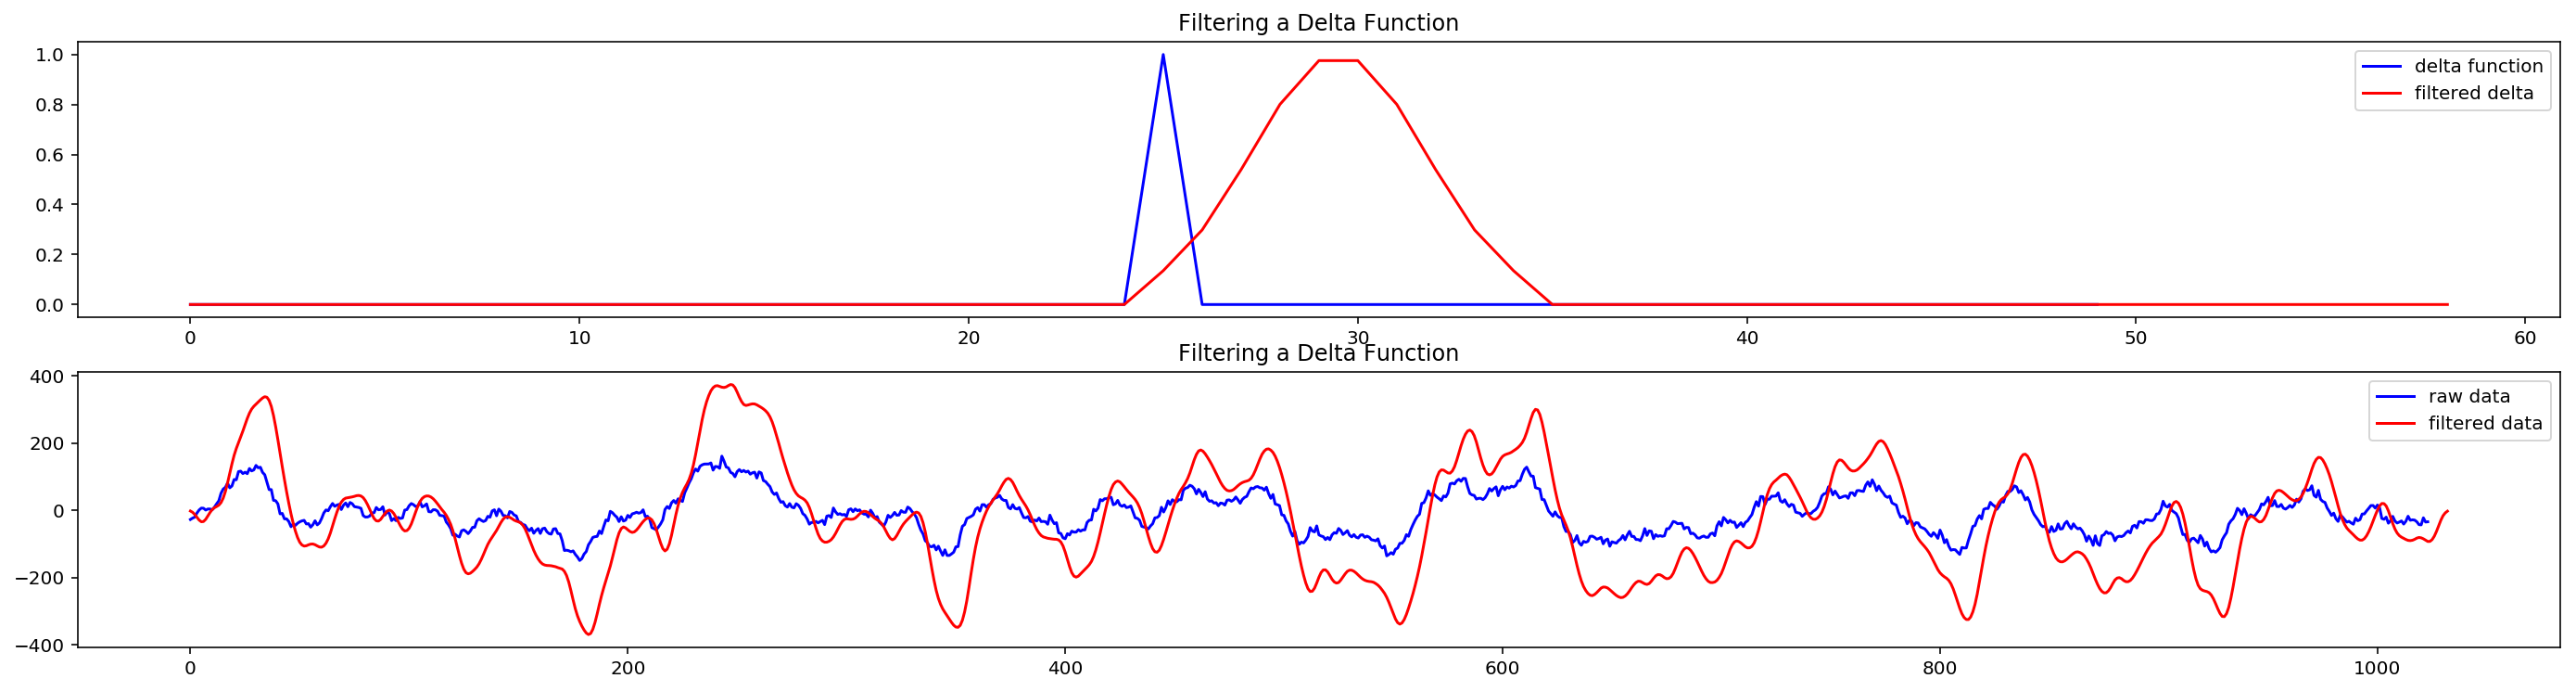

In [7]:
delta_funct = np.zeros((50));
delta_funct[len(delta_funct)//2] = 1;


dat = data[0:1024];

#kernel 1: Gaussian Filter
x = np.linspace(0, 1, 10) #size of filter

mu = .5;
sig =.25;  ##
def generate_gaussian_filter(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)));

gaussian_filter = generate_gaussian_filter(x, mu, sig);

convolved_delt = sp.signal.convolve(delta_funct,gaussian_filter)
convolved_dat = sp.signal.convolve(dat,gaussian_filter)

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(2, 1, 1);
ax1.plot(delta_funct,color = 'b',label = 'delta function')
ax1.plot(convolved_delt,color = 'r',label = 'filtered delta')
legend()
title('Filtering a Delta Function')


ax2 = fig.add_subplot(2, 1, 2);
ax2.plot(dat*2,color = 'b',label = 'raw data') #multiplied by 2 to scale to filtered data
ax2.plot(convolved_dat,color = 'r',label = 'filtered data')
legend()
title('Filtering a Delta Function')

Something looks wrong. 

Why is the filtered data shifted over to the right in both graphs?

To answer this, let's look at the filtered delta function.

A convolution is the same as sliding our kernal over the data and multiplying our data by each point in the kernal. As the gaussian filter slid left to right across 0's each point was multiplied by 0, resulting in nothing. However, when the nose of the gaussian filter reached the 1 in the delta function, it multiplied the leading non-zero value of the gaussian by 1. As we kept pushing the shape through, each point in the filter was multiplied by 1. You'll see that the length of the vector produced by the convolution is the length of the data + the length of the filter - 1. This happened beacuse had to multiply each point in the data by both the nose and the tail of the kernal, resulting in some extra points. Because we simply multiplied each point in the kernal by 1, convolving a delta function with any filter will perfectly reproduce the kernal.

What if we don't want our filtered data to be shifted? And how come the filtered data a few cells above isn't shifted?

In the next cell I'll show you some simple ways to get rid of this shift.

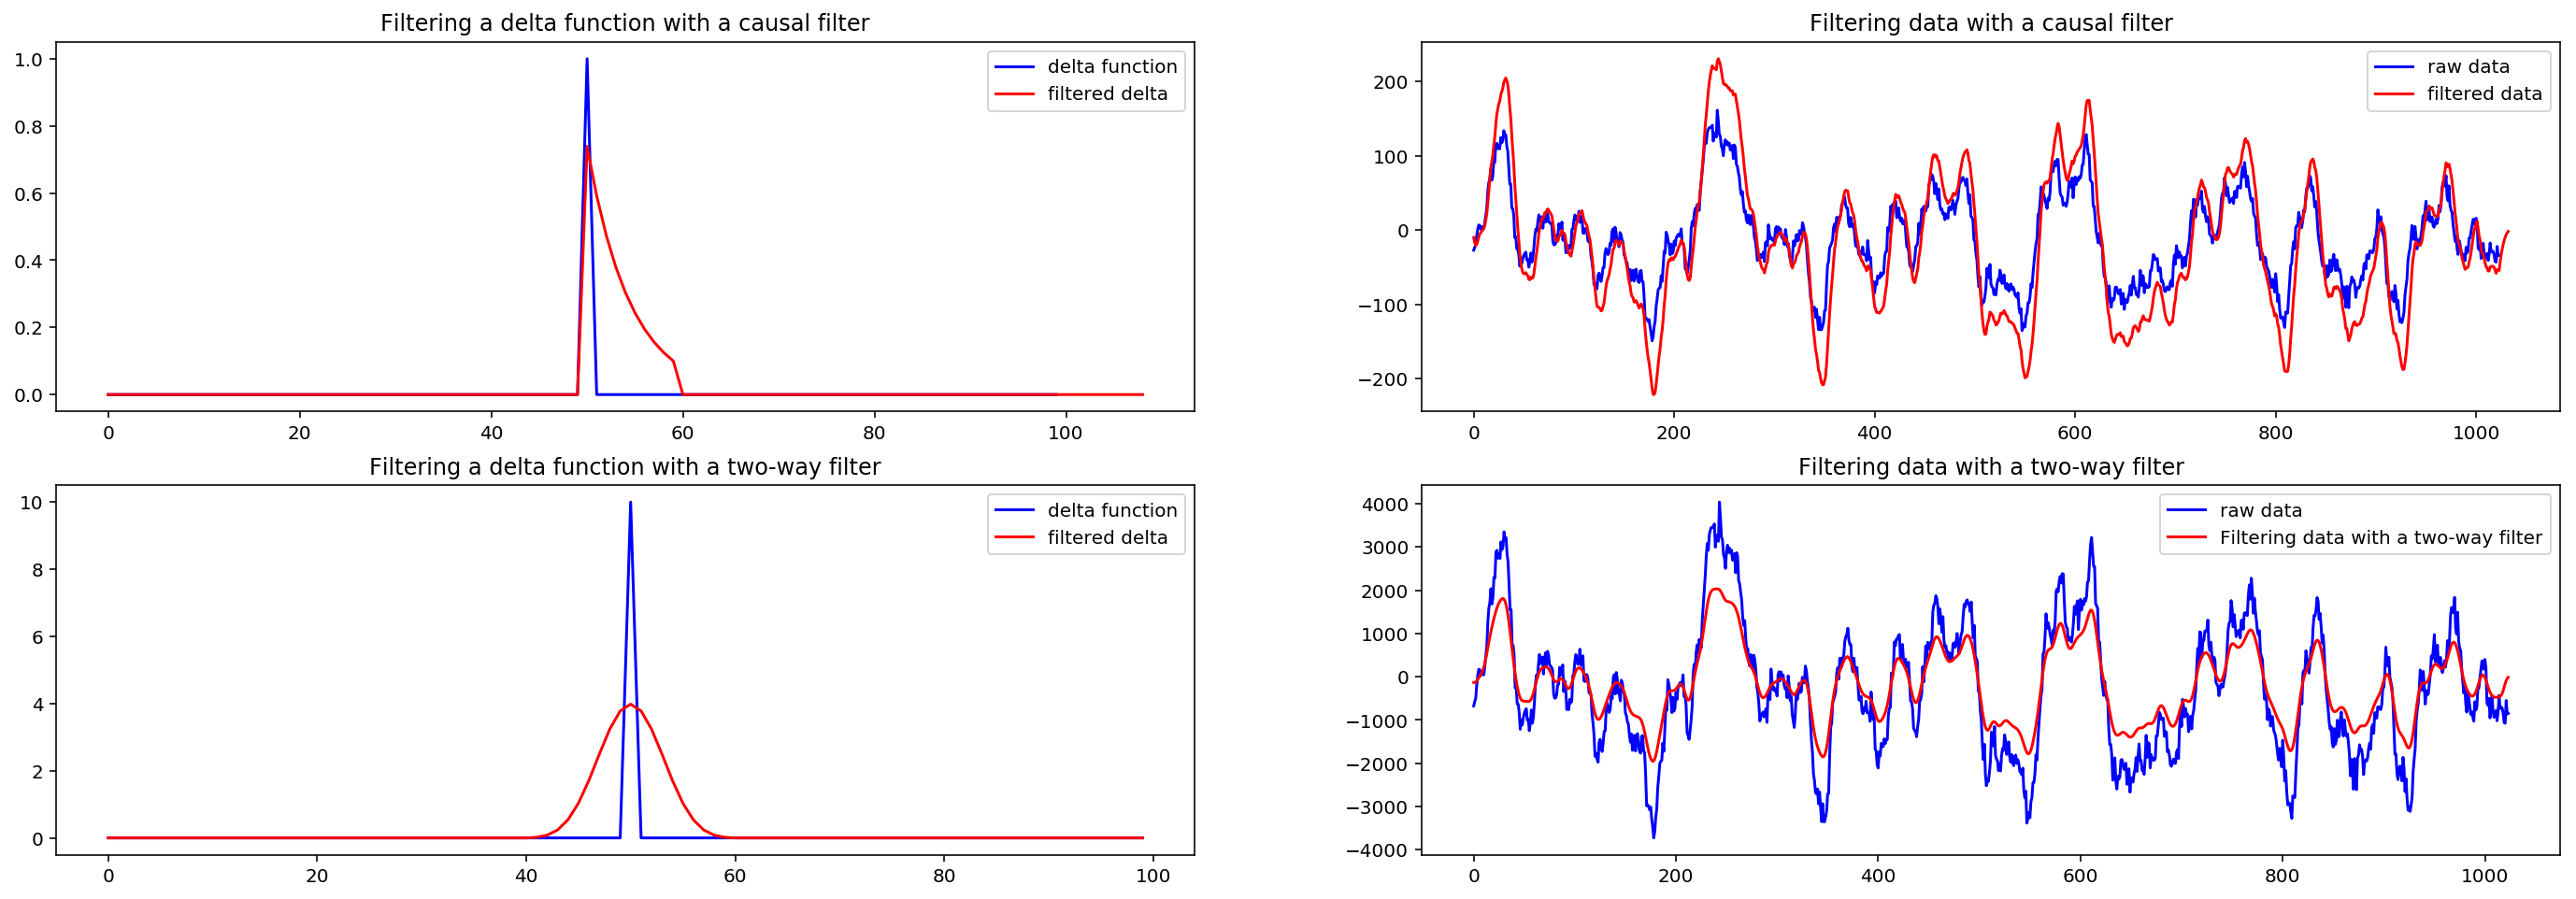

In [9]:
dat = data[0:1024];

#time lag resistant kernel #1: Causal Filter (exponential filter)
#filter parameters
x = np.linspace(0, 1, 10) #size of filter
tau = .5;
amp_reduct = .1;
def generate_causal_filter(x,tau,amp_reduct):
    return list(reversed(amp_reduct*np.exp(x/tau)));

causal_filter = generate_causal_filter(x,tau,amp_reduct);
delta_funct = np.zeros((100));
delta_funct[len(delta_funct)//2] = 1;

convolved_delt_causal_filt = sp.signal.convolve(delta_funct,causal_filter)
convolved_dat_causal_filt = sp.signal.convolve(dat,causal_filter)


#time lag resistant kernel #2: Two-way Filter
convolved_delt_two_way = sp.signal.convolve(delta_funct,gaussian_filter)
convolved_delt_two_way = convolved_delt_two_way[0:len(delta_funct)]
convolved_delt_two_way = sp.signal.convolve(list(reversed(convolved_delt_two_way)),gaussian_filter)
convolved_delt_two_way = list(reversed(convolved_delt_two_way[0:len(delta_funct)]))

convolved_dat_two_way = sp.signal.convolve(dat,gaussian_filter)
convolved_dat_two_way = convolved_dat_two_way[0:len(dat)]
convolved_dat_two_way = sp.signal.convolve(list(reversed(convolved_dat_two_way)),gaussian_filter)
convolved_dat_two_way = list(reversed(convolved_dat_two_way[0:len(dat)]))

#plotting
fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(2, 2, 1);
ax1.plot(delta_funct,color = 'b',label = 'delta function')
ax1.plot(convolved_delt_causal_filt,color = 'r',label = 'filtered delta')
legend()
title('Filtering a delta function with a causal filter')

ax2 = fig.add_subplot(2, 2, 2);
ax2.plot(dat*2,color = 'b',label = 'raw data') #multiplied by 2 to scale to filtered data
ax2.plot(convolved_dat_causal_filt,color = 'r',label = 'filtered data')
title('Filtering data with a causal filter')
legend()

ax3 = fig.add_subplot(2, 2, 3);
ax3.plot(delta_funct*10,color = 'b',label = 'delta function')
ax3.plot(convolved_delt_two_way,color = 'r',label = 'filtered delta')
legend()
title('Filtering a delta function with a two-way filter')

ax4 = fig.add_subplot(2, 2, 4);
ax4.plot(dat*50,color = 'b',label = 'raw data')
ax4.plot(convolved_dat_two_way, color = 'r', label = 'Filtering data with a two-way filter')
title('Filtering data with a two-way filter')
legend()


One way of getting rid of dealing with time lag is to have a filter with no leading tail like we do here with a causal filter.

Another way is to perform a convolution on the data with a filter kernal, then convolve the convolved data again, backwards. This works because convolving the convolved data backwards reverses any time lag, exactly. This is what the sp.signal.filtfilt method in one of the first cells does. Try replacing sp.signal.filtfilt with sp.signal.lfilter and you'll see the time lag occur.

There are many, many filtering methods and these are just a few simple ones. There is no such thing as a perfect filter. Some filtering methods are better for certain uses and picking the best one takes some expertise.  

What we learned:
- Filters help us see what is going on in different frequency ranges in data
- You can apply a filter to data in just a few lines of code
- Filters work by convolving a shape with your data, the same as multiplying everything on a sliding window
- Time delay in filtering is a problem that can be solved.
